Buid a basic chatbot with LangGraph(Graph API)

In [5]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

In [6]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

In [7]:
import os
from dotenv import load_dotenv
load_dotenv()

True

In [8]:
from langchain_groq import ChatGroq
from langchain.chat_models import init_chat_model

llm=ChatGroq(model="llama3-8b-8192")

In [68]:
# llm=init_chat_model("groq:llama3-8b-8192")

In [69]:
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x000002074AB38690>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x000002074AB39090>, model_name='llama3-8b-8192', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [9]:
def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}

In [71]:
graph_builder = StateGraph(State)
graph_builder.add_node("llmchatbot",chatbot)

graph_builder.add_edge(START, "llmchatbot")
graph_builder.add_edge("llmchatbot", END)

graph = graph_builder.compile()

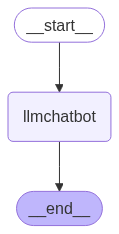

In [72]:
from IPython.display import display, Image

display(Image(graph.get_graph().draw_mermaid_png()))

In [73]:
response = graph.invoke({"messages": "Hi"})

In [74]:
response["messages"][-1].content

"Hi! It's nice to meet you. Is there something I can help you with or would you like to chat?"

In [75]:
for event in graph.stream({"messages": "Hi, How are you?"}):
    for value in event.values():
        print(value["messages"][-1].content)

Hi! I'm just a language model, so I don't have feelings or emotions like humans do. However, I'm functioning properly and ready to help you with any questions or tasks you may have! How can I assist you today?


ChatBot with tools

In [12]:
from langchain_tavily import TavilySearch

tool=TavilySearch(max_results=2)

In [10]:
def multiply(a: int, b: int) -> int:
    """
    Multiply two integers and return the result.

    Args:
        a (int): The first integer.
        b (int): The second integer.

    Returns:
        int: The product of a and b.
    """ 
    return a * b

In [13]:
tools = [tool, multiply]

In [14]:
llm_with_tools=llm.bind_tools(tools)

In [80]:
llm_with_tools

RunnableBinding(bound=ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x000002074AB38690>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x000002074AB39090>, model_name='llama3-8b-8192', model_kwargs={}, groq_api_key=SecretStr('**********')), kwargs={'tools': [{'type': 'function', 'function': {'name': 'tavily_search', 'description': 'A search engine optimized for comprehensive, accurate, and trusted results. Useful for when you need to answer questions about current events. It not only retrieves URLs and snippets, but offers advanced search depths, domain management, time range filters, and image search, this tool delivers real-time, accurate, and citation-backed results.Input should be a search query.', 'parameters': {'properties': {'query': {'description': 'Search query to look up', 'type': 'string'}, 'include_domains': {'anyOf': [{'items': {'type': 'string'}, 'type': 'array'}, {'type': 'null'}], 'default': [], 'description': 'A list 

In [81]:
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition

def tool_calling_llm(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

builder=StateGraph(State)
builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges("tool_calling_llm", tools_condition)
builder.add_edge("tools", "tool_calling_llm")
builder.add_edge("tool_calling_llm", END)

graph=builder.compile()

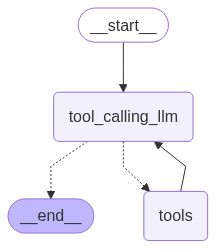

In [82]:
from IPython.display import display, Image

display(Image(graph.get_graph().draw_mermaid_png()))

In [83]:
response=graph.invoke({"messages": "what is the recent ai news and then multiply 2 and 3?"})

for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

what is the recent ai news and then multiply 2 and 3?
================================== Ai Message ==================================
Tool Calls:
  tavily_search (qab0sr2g2)
 Call ID: qab0sr2g2
  Args:
    query: recent ai news
    search_depth: advanced
    topic: news
  multiply (fjf02w3hb)
 Call ID: fjf02w3hb
  Args:
    a: 2
    b: 3
================================= Tool Message =================================
Name: tavily_search

{"query": "recent ai news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.zdnet.com/article/microsoft-is-saving-millions-with-ai-and-laying-off-thousands-where-do-we-go-from-here/", "title": "Microsoft is saving millions with AI and laying off thousands - where do we go from here? - ZDNET", "score": 0.7244226, "published_date": "Thu, 17 Jul 2025 02:00:00 GMT", "content": "The news comes as several tech companies and leaders h

Adding memory in Agentic

In [84]:
response = graph.invoke({"messages": "Hi my name is sanjai"})
for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

Hi my name is sanjai
================================== Ai Message ==================================

Nice to meet you, Sanjai! How can I help you today?


In [87]:
response = graph.invoke({"messages": "what is my name?"})
for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

what is my name?
================================== Ai Message ==================================

</tool-use>
{
  "tool_calls": [
    {
      "id": "pending",
      "type": "function",
      "function": {
        "name": "get_name"
      },
      "parameters": {}
    }
  ]
}
</tool-use>


In [15]:
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

def tool_calling_llm(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

builder=StateGraph(State)
builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges("tool_calling_llm", tools_condition)
builder.add_edge("tools", "tool_calling_llm")
builder.add_edge("tool_calling_llm", END)

graph=builder.compile(checkpointer=memory)

In [93]:
config = {"configurable": {"thread_id": "1"}}

response = graph.invoke({"messages": "Hi my name is sanjai"}, config=config)
response

{'messages': [HumanMessage(content='Hi my name is sanjai', additional_kwargs={}, response_metadata={}, id='0c96bb7c-59d7-40bf-b1ad-809e7eb1f362'),
  AIMessage(content='Nice to meet you, Sanjai! What brings you here today? Would you like to ask me a question or discuss something with me?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 30, 'prompt_tokens': 2200, 'total_tokens': 2230, 'completion_time': 0.036507559, 'prompt_time': 0.244900021, 'queue_time': 0.2779981690000001, 'total_time': 0.28140758}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_0fb809dba3', 'finish_reason': 'stop', 'logprobs': None}, id='run--ffc85282-d513-437e-b15c-b18a2d0575e4-0', usage_metadata={'input_tokens': 2200, 'output_tokens': 30, 'total_tokens': 2230})]}

In [94]:
response['messages'][-1].content

'Nice to meet you, Sanjai! What brings you here today? Would you like to ask me a question or discuss something with me?'

In [97]:
config = {"configurable": {"thread_id": "1"}}

response = graph.invoke({"messages": "do you remember my name?"}, config=config)
response['messages'][-1].content

'Yes, I remember your name is Sanjai.'

Streaming

In [16]:
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()

In [17]:
def superbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}

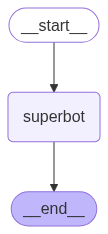

In [25]:
graph = StateGraph(State)

graph.add_node("superbot", superbot)

graph.add_edge(START, "superbot")
graph.add_edge("superbot", END)

graph_builder = graph.compile(checkpointer=memory)

from IPython.display import display, Image
display(Image(graph_builder.get_graph().draw_mermaid_png()))

In [28]:
config = {"configurable": {"thread_id": "1"}}

for chunk in graph_builder.stream({"messages": "Hi my name is sanjai and i like batmitton."}, config=config, stream_mode='updates'):
    print(chunk)

{'superbot': {'messages': [AIMessage(content='Hi Sanjai! It seems like you\'re still having a bit of a typo, and I\'m assuming you meant to say "Batman" instead of "Batmitton"? If you\'re willing to share, what do you like about Batman?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 51, 'prompt_tokens': 440, 'total_tokens': 491, 'completion_time': 0.054954185, 'prompt_time': 0.050658901, 'queue_time': 0.274945678, 'total_time': 0.105613086}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_5b339000ab', 'finish_reason': 'stop', 'logprobs': None}, id='run--57a9fb49-451e-4f80-b4a2-fb6d568bb35c-0', usage_metadata={'input_tokens': 440, 'output_tokens': 51, 'total_tokens': 491})]}}


In [29]:
config = {"configurable": {"thread_id": "1"}}

for chunk in graph_builder.stream({"messages": "Hi my name is sanjai and i like batmitton."}, config=config, stream_mode='values'):
    print(chunk)

{'messages': [HumanMessage(content='Hi my name is sanjai and i like batmitton', additional_kwargs={}, response_metadata={}, id='f06b25de-aaf2-4201-9fcd-c78c02e09cc4'), AIMessage(content="Hi Sanjai! That's a great interest to have! Batman is an iconic superhero with a rich history in comics, movies, and TV shows. Which aspect of Batman do you enjoy the most? Is it the Dark Knight's detective skills, his gadgets, his rivalries with the Joker or other villains, or something else?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 68, 'prompt_tokens': 23, 'total_tokens': 91, 'completion_time': 0.070510145, 'prompt_time': 0.006429735, 'queue_time': 0.273516248, 'total_time': 0.07693988}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_5b339000ab', 'finish_reason': 'stop', 'logprobs': None}, id='run--eea77f29-045c-4ca7-a4d9-9d06308a92b3-0', usage_metadata={'input_tokens': 23, 'output_tokens': 68, 'total_tokens': 91}), HumanMessage(content='Hi my name is

In [32]:
config = {"configurable": {"thread_id": "1"}}

async for chunk in graph_builder.astream_events({"messages": "Hi my name is sanjai and i like batmitton."}, config=config, version='v2'):
    print(chunk)

{'event': 'on_chain_start', 'data': {'input': {'messages': 'Hi my name is sanjai and i like batmitton.'}}, 'name': 'LangGraph', 'tags': [], 'run_id': '5573b532-11fe-4b02-90bd-fe9bdea01b0a', 'metadata': {'thread_id': '1'}, 'parent_ids': []}
{'event': 'on_chain_start', 'data': {'input': {'messages': [HumanMessage(content='Hi my name is sanjai and i like batmitton', additional_kwargs={}, response_metadata={}, id='f06b25de-aaf2-4201-9fcd-c78c02e09cc4'), AIMessage(content="Hi Sanjai! That's a great interest to have! Batman is an iconic superhero with a rich history in comics, movies, and TV shows. Which aspect of Batman do you enjoy the most? Is it the Dark Knight's detective skills, his gadgets, his rivalries with the Joker or other villains, or something else?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 68, 'prompt_tokens': 23, 'total_tokens': 91, 'completion_time': 0.070510145, 'prompt_time': 0.006429735, 'queue_time': 0.273516248, 'total_time': 0.0769